# Push your sales with SPC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel('DDDD.xlsx',parse_dates=['SalesDate'], usecols="A,C") # we only import column A and column C, SalesDate and SalesAmount

TimeSeriesGroup = df.set_index('SalesDate')
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,13))

# note that all days in between our time series get plotted, even if no sales exist. That's the reason for the many 0 values.
ax1.plot(TimeSeriesGroup['SalesAmount'].resample('D').sum(),marker='o')
ax1.set_title('Daily');

ax2.plot(TimeSeriesGroup['SalesAmount'].resample('MS').sum(),marker='o')
ax2.set_title('Monthly');

ax3.plot(TimeSeriesGroup['SalesAmount'].resample('A').sum(),marker='o')
ax3.set_title('Yearly');

C:\Users\jesko\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


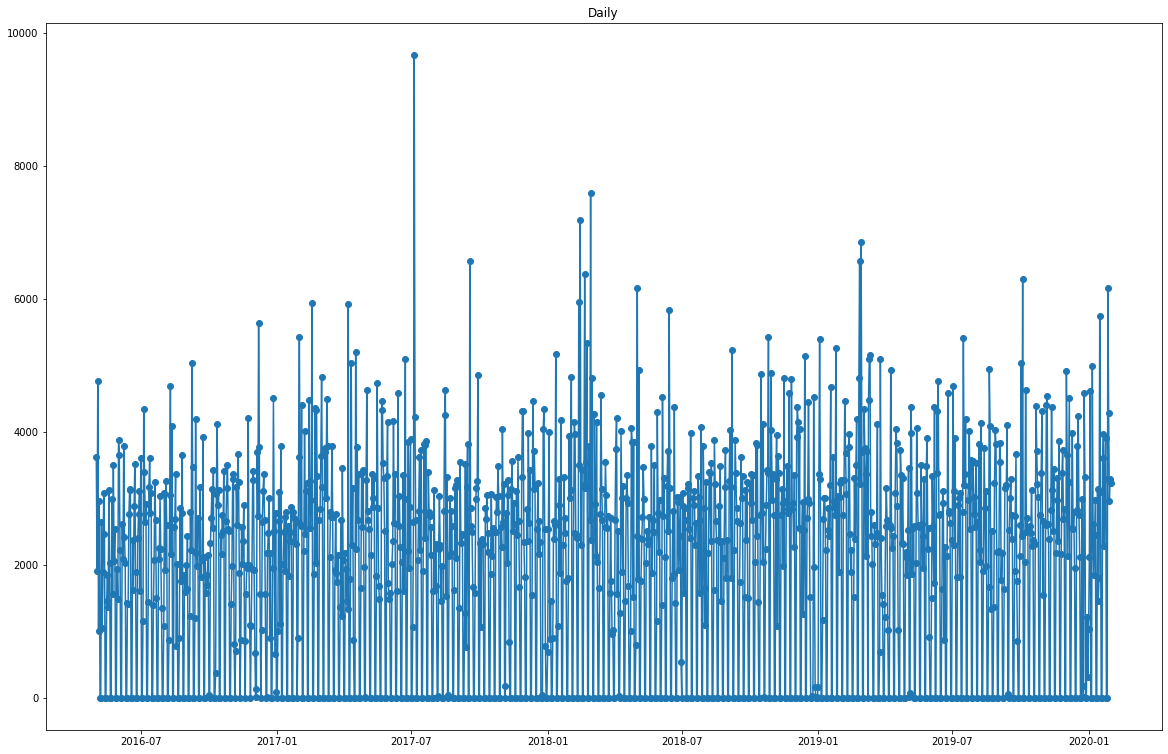

In [2]:
# note that all days in between our time series get plotted, even if no sales exist. That's the reason for the many 0 values.
fig, (DailySum) = plt.subplots(1,figsize=(20,13))
DailySum.plot(TimeSeriesGroup['SalesAmount'].resample('D').sum(),marker='o')
DailySum.set_title('Daily');
# Daily data has at least two extreme outliers. Remember that average values are highly influenced by outliers.

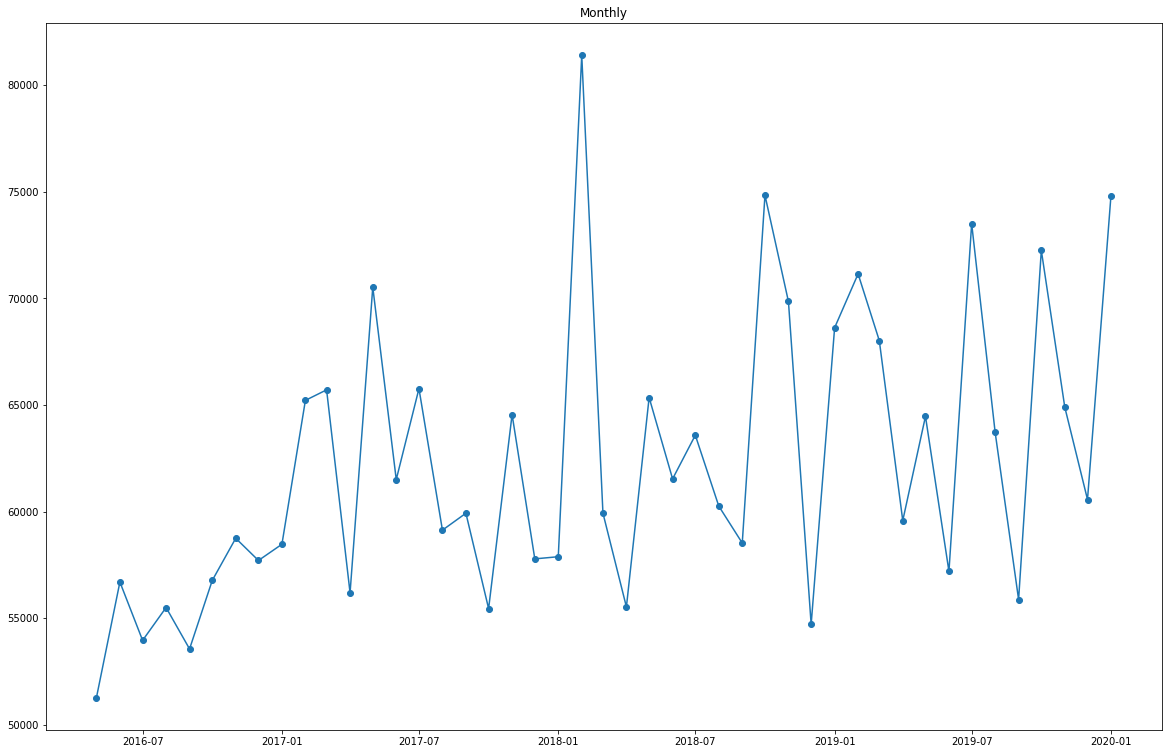

In [3]:
# I would stick to summing sales amount instead of averaging. 
fig, (MonthlySum) = plt.subplots(1,figsize=(20,13))
MonthlySum.plot(TimeSeriesGroup['SalesAmount'].resample('MS').sum(),marker='o')
MonthlySum.set_title('Monthly');

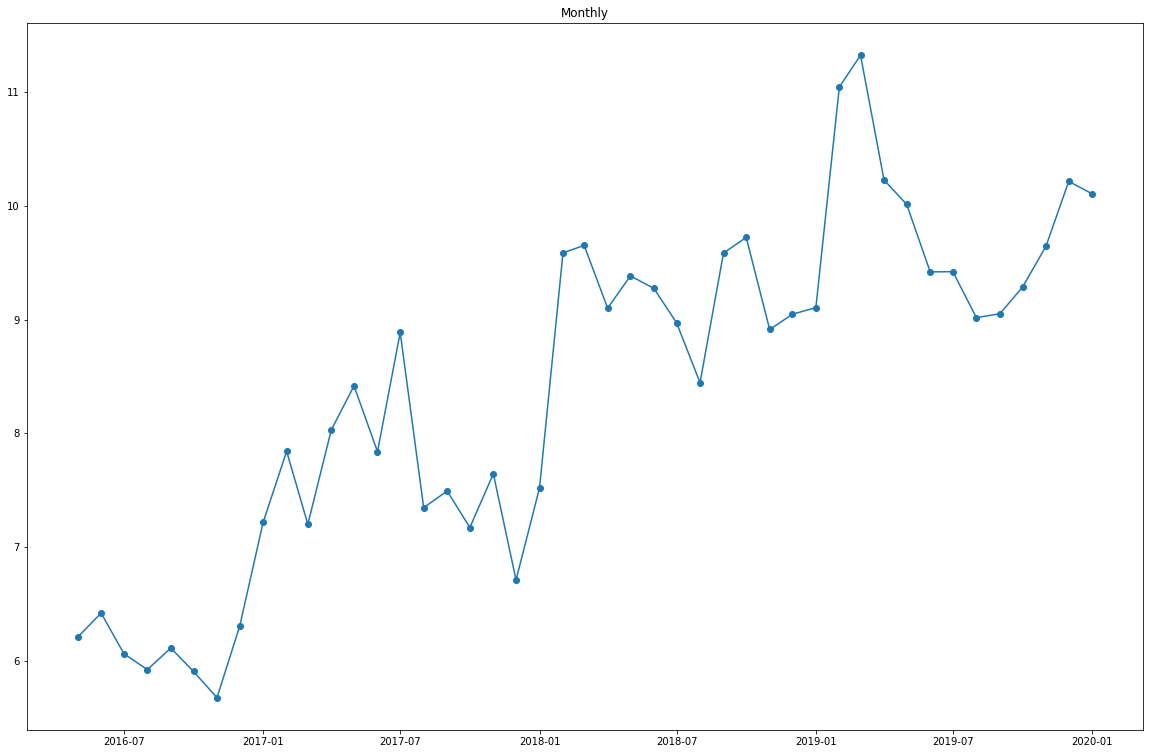

In [4]:
# Averages will result in loss of information and smoothes data.
fig, (MonthlyMean) = plt.subplots(1,figsize=(20,13))
MonthlyMean.plot(TimeSeriesGroup['SalesAmount'].resample('MS').mean(),marker='o')
MonthlyMean.set_title('Monthly');
# From daily to monthly we can clearly see the overall rising positive sales trend.

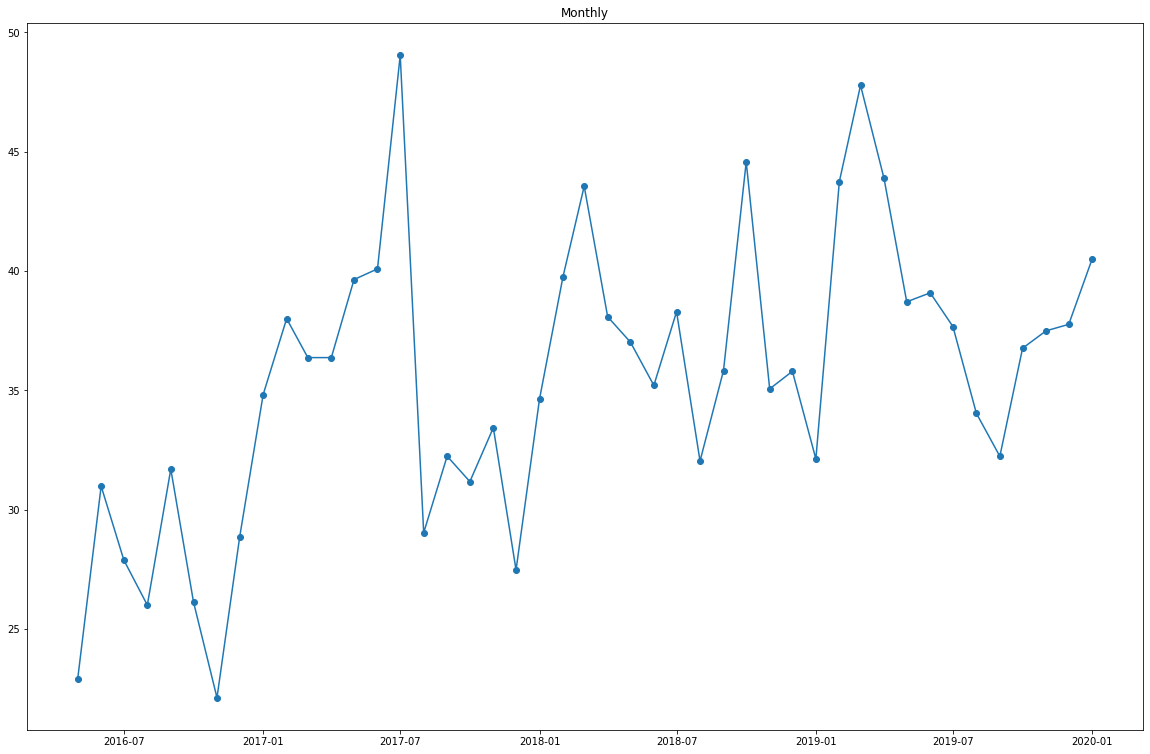

In [5]:
# Mean and Sum alone are not enough, we also need to understand the range in our sales activities. The standard deviation will
# tell us how much variance around the mean we can expect in our sales.
fig, (MonthlyStd) = plt.subplots(1,figsize=(20,13))
MonthlyStd.plot(TimeSeriesGroup['SalesAmount'].resample('MS').std(),marker='o')
MonthlyStd.set_title('Monthly');

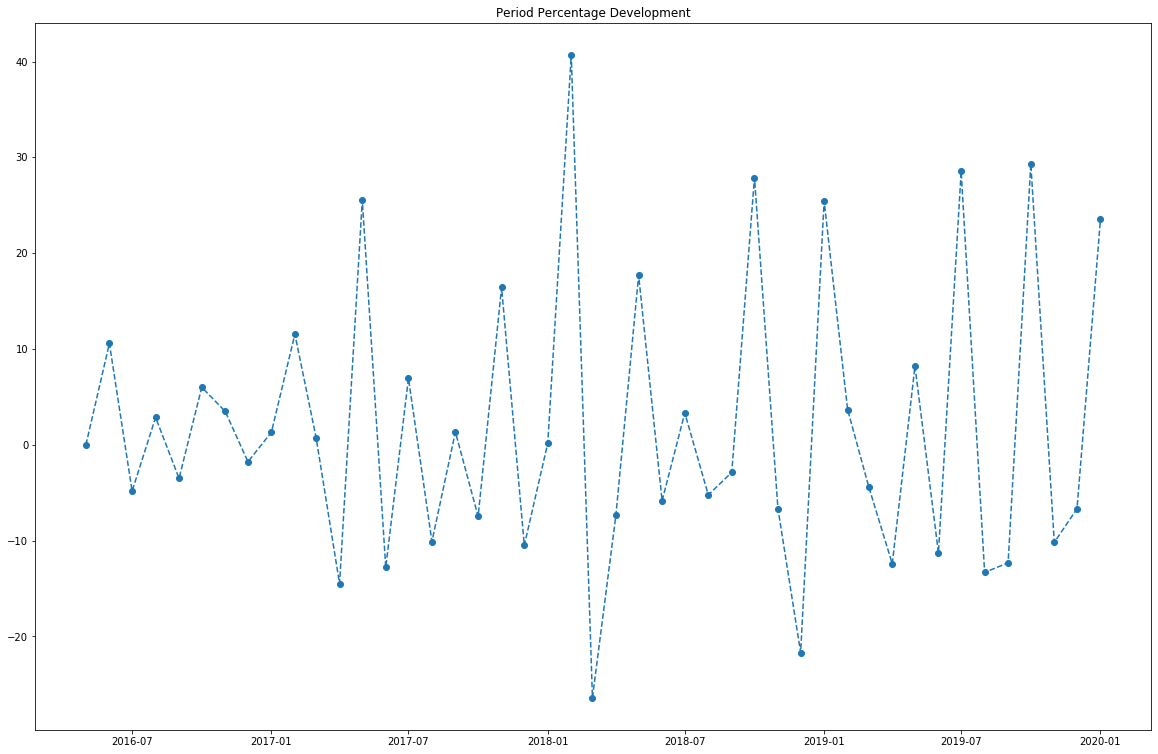

In [6]:
MonthDevelop = df.set_index('SalesDate')
PeriodDevelop = MonthDevelop.resample('MS').sum() # grouping SalesAmount on a monthly basis, for each Month Start 'MS'
PeriodDevelop['PercentageDevelopment']=PeriodDevelop.pct_change().fillna(0)*100
fig, (ax1) = plt.subplots(1,figsize=(20,13))
ax1.plot(PeriodDevelop.PercentageDevelopment,marker='o', linestyle='--')
ax1.set_title('Period Percentage Development');

In [7]:
#PeriodDevelop # e.g. (51265-56692)/51265 --> 0.1058617 *100% (positive increase)

In [8]:
PeriodDevelop2 = PeriodDevelop.reset_index() #drop=False
PeriodDevelop2['Month'] = pd.DatetimeIndex(PeriodDevelop2['SalesDate']).month
PeriodDevelop3=PeriodDevelop2.query('SalesDate != "2016-05-01"')
PeriodDevelop3=PeriodDevelop3.groupby(['Month']).mean()
PeriodDevelop3.head()

SalesAmount  PercentageDevelopment
Month                                     
1      64949.750000              12.623874
2      72594.333333              18.629866
3      64553.666667             -10.010749
4      57095.000000             -11.420544
5      66782.333333              17.145988

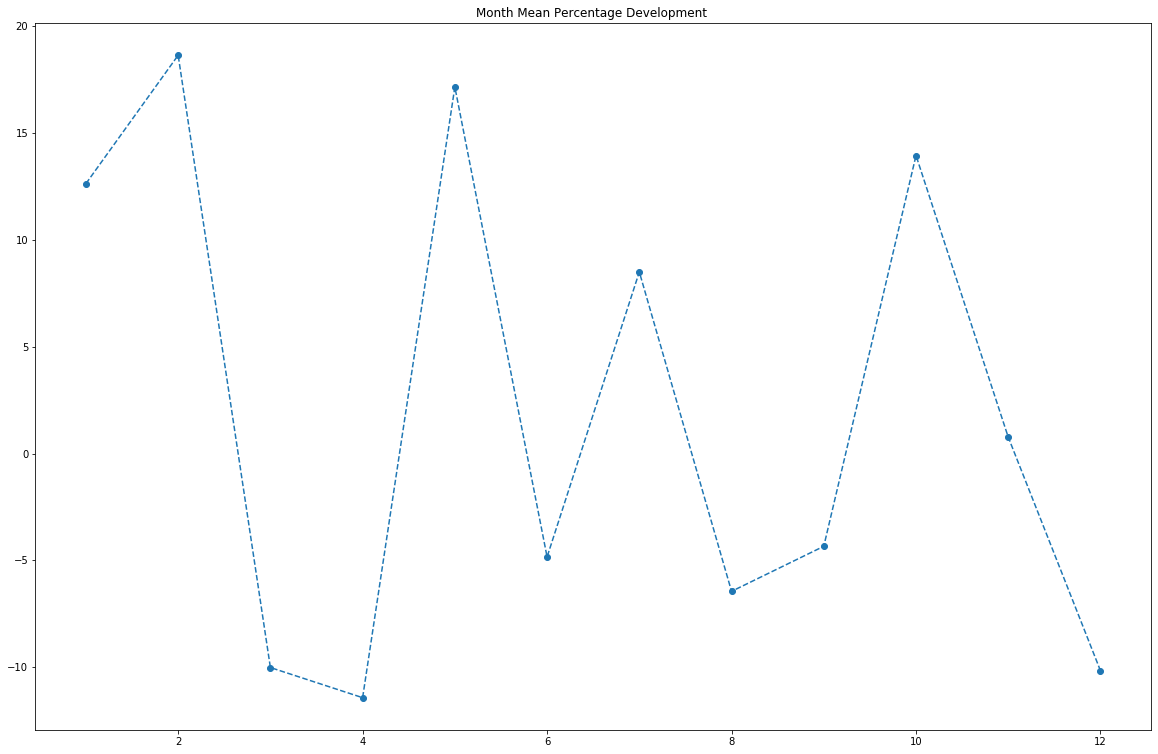

In [9]:
fig, (ax1) = plt.subplots(1,figsize=(20,13))
ax1.plot(PeriodDevelop3.PercentageDevelopment,marker='o', linestyle='--')
ax1.set_title('Month Mean Percentage Development ');

In [10]:
import plotly.express as px
DaysPerMonth = df.set_index('SalesDate')
BoxPlot = DaysPerMonth.resample('d').sum() # grouping SalesAmount on a daily level
BoxPlotJan2018=BoxPlot.loc['2018-01-01':'2018-01-31'] 
fig = px.box(BoxPlotJan2018, y=BoxPlotJan2018['SalesAmount']) 
fig.show()

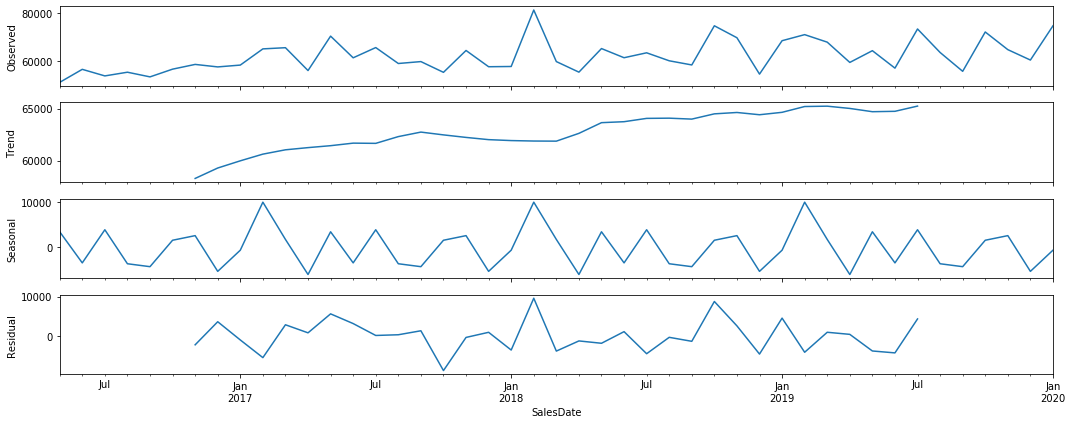

In [11]:
#Depending on the nature of the trend and seasonality, a time series can be modelled as an additive or multiplicative, wherein,
#each observation in the series can be expressed as either a sum or a product of the components:

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.testing import assert_frame_equal

from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#Check for any outliers and decide if they should be included before training your model
df['SalesDate'] = pd.to_datetime(df['SalesDate'])
df = df.set_index('SalesDate')
MonthlyDf = df.resample('MS').sum()#D vs resample(ms); M monthhly vs D daily ws weekly w, M End of month, MS start of month


decomposition = sm.tsa.seasonal_decompose(MonthlyDf, model='additive')
#An additive (model is made up of observed, trend, seasonal and residual (noise) components) model is linear where changes 
#over time are consistently made by the same amount. A linear seasonality has the same frequency (width of cycles) and 
#amplitude (height of cycles).
fig = decomposition.plot()
plt.show()
#trend is associated with the slope (increasing/decreasing) of the time series
#seasonality which is the deviations from the mean caused by repeating short-term cycles and
#noise is the random variation in the series

In [12]:
#Now wouldn't it be nice if we could combine both monthly totals, overall mean, moving range, and standard deviation into one overview so we can more easily detect unusual sales point over time?

# QCC

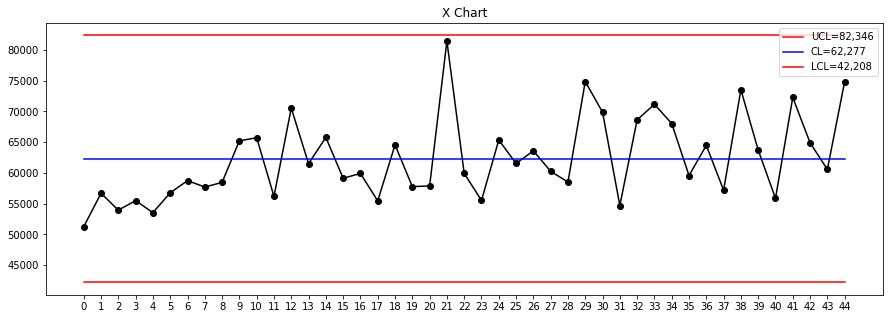

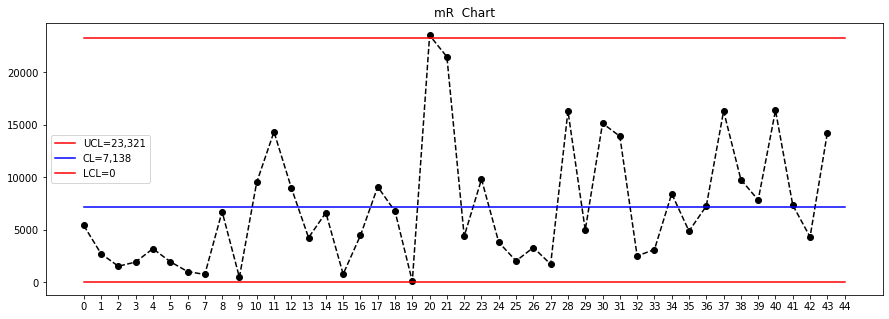

In [13]:
import numpy as np
import matplotlib.pyplot as plt

class SPC:
    def fit(self,data):
        self.X = data
        self.number_of_sample = len(self.X)
        self.mR = np.zeros(((self.number_of_sample-1),1))
        for i in range(len(self.mR)):
            self.mR[i] = abs(self.X[i+1] - self.X[i])
    def QCC(self): 
        ucl_X   = self.X.mean() + (3*self.X.std())
        cl_X    = self.X.mean() 
        lcl_X   = self.X.mean() - (3*self.X.std())
       
        ucl_mR   = 3.267*self.mR.mean()
        cl_mR    = self.mR.mean() 
        lcl_mR = 1-3*0.853/1.128 if 1-3*0.853/1.128 > 0 else 0

        plt.figure(figsize=(15,5))
        plt.plot(self.X,marker="o",color="k") 
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_X)) 
        plt.plot([cl_X]*len(self.X),color="b",label="CL={:,.0f}".format(cl_X))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={:,.0f}".format(lcl_X))
        plt.title("X Chart")
        plt.xticks(np.arange(len(self.X)))
        plt.legend()
        plt.show()

        plt.figure(figsize=(15,5))
        plt.plot(self.mR ,marker="o",color="k", linestyle='--') 
        plt.plot([ucl_mR ]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_mR))
        plt.plot([cl_mR ]*len(self.X),color="b",label="CL={:,.0f}".format(cl_mR))
        plt.plot([lcl_mR ]*len(self.X),color="r",label="LCL={:,.0f}".format(round(lcl_mR,0)))
        plt.title("mR  Chart")
        plt.xticks(np.arange(len(self.X)))
        plt.legend()
        plt.show()

        
plt.style.use('seaborn-colorblind')
chart = SPC()
chart.fit(MonthlyDf['SalesAmount'].to_numpy())
chart.QCC()  

Skewness: 0.789845
Kurtosis: 0.138782


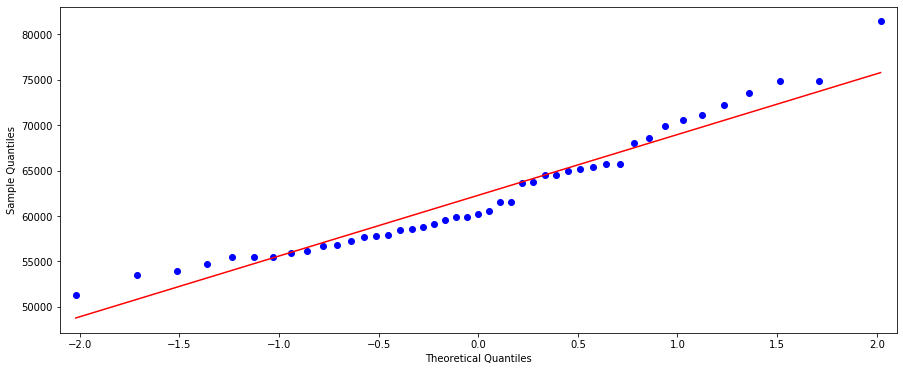

Statistics=0.943, p=0.029
Sales data does not seem to be describable as normal distributed (reject H0).


count       45.000000
mean     62276.955556
std       6765.216552
min      51265.000000
25%      57192.000000
50%      60256.000000
75%      65711.000000
max      81414.000000
Name: SalesAmount, dtype: float64

In [14]:
# Histogram will help us in understanding how sales amount is distributed
import plotly.offline as pyoff
import plotly.graph_objs as go
plot_data = [
    go.Histogram(
        x=MonthlyDf['SalesAmount']
    )
]
plot_layout = go.Layout(
        title='SalesAmount'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# with Plotly we can mouse over the bars to see the values. We can even zoom into our visualization for further details.
# We can see at a glance that there is one extremely high sales

# histogram does not look like sales data could be described as normal distributed
# adding skewness and kurtosis as a statistical support to the above histogram
print("Skewness: %f" % MonthlyDf['SalesAmount'].skew())
print("Kurtosis: %f" % MonthlyDf['SalesAmount'].kurt())

# The value of the skewness is positive, because the tail of the distribution is longer towards the right hand side of the curve.
# It is not symmetrically distributed. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a
# normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers.

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot(MonthlyDf['SalesAmount'], line='s')
pyplot.show()

from scipy.stats import shapiro
stat, p = shapiro(MonthlyDf['SalesAmount'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sales data does seem to be describable as normal distributed (fail to reject H0).')
else:
    print('Sales data does not seem to be describable as normal distributed (reject H0).')
    
# basic statistics, see also Box Plot
MonthlyDf['SalesAmount'].describe()

# Splitting into sub-processes

In [15]:
FilteredDate1=MonthlyDf.loc['2016-05-01':'2017-01-01'] 

FilteredDate2=MonthlyDf.loc['2017-02-01':'2018-01-01'] 
#FilteredDate2=MonthlyDf.loc['2017-02-01':'2018-09-01'] 

FilteredDate3=MonthlyDf.loc['2018-02-01':'2020-01-01'] 
#FilteredDate3=MonthlyDf.loc['2018-10-01':'2020-01-01'] 

Skewness: -0.667262
Kurtosis: -0.409946


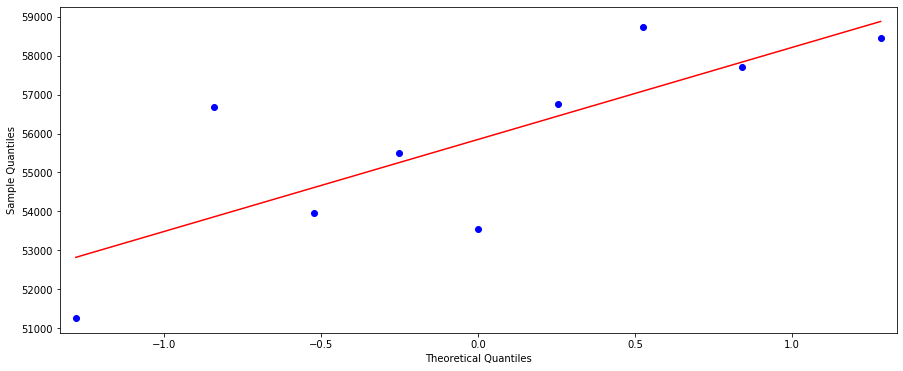

Statistics=0.937, p=0.551
Sales data does seem to be describable as normal distributed (fail to reject H0).


SalesAmount
count      9.000000
mean   55849.111111
std     2505.922956
min    51265.000000
25%    53954.000000
50%    56692.000000
75%    57704.000000
max    58746.000000

In [16]:
import plotly.offline as pyoff
import plotly.graph_objs as go
plot_data = [
    go.Histogram(
        x=MonthlyDf.loc['2016-05-01':'2017-01-01']
    )
]
plot_layout = go.Layout(
        title='SalesAmount'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

print("Skewness: %f" % MonthlyDf.loc['2016-05-01':'2017-01-01'].skew())
print("Kurtosis: %f" % MonthlyDf.loc['2016-05-01':'2017-01-01'].kurt())

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot(MonthlyDf.loc['2016-05-01':'2017-01-01'], line='s')
pyplot.show()

from scipy.stats import shapiro
stat, p = shapiro(MonthlyDf.loc['2016-05-01':'2017-01-01'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sales data does seem to be describable as normal distributed (fail to reject H0).')
else:
    print('Sales data does not seem to be describable as normal distributed (reject H0).')
    
MonthlyDf.loc['2016-05-01':'2017-01-01'].describe()

In [17]:
class SPC:
    def fit(self,data):
        self.X = data
        #print(self.X)
        self.number_of_sample = len(self.X)
        #print(self.number_of_sample)
        self.mR = np.zeros(((self.number_of_sample-1),1))
        #print("selfmr" +str(self.mR))
        for i in range(len(self.mR)):
            self.mR[i] = abs(self.X[i+1] - self.X[i])
            #print("i content"+str(i))
            #print(self.mR[i])
    def QCC(self): 
        ucl_X   = self.X.mean() + (3*self.X.std())
        cl_X    = self.X.mean() 
        lcl_X   = self.X.mean() - (3*self.X.std())
       
        ucl_mR   = 3.267*self.mR.mean()
        cl_mR    = self.mR.mean() 
        lcl_mR = 1-3*0.853/1.128 if 1-3*0.853/1.128 > 0 else 0

        plt.figure(figsize=(15,5))
        plt.plot(self.X,marker="o",color="k") 
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_X)) 
        plt.plot([cl_X]*len(self.X),color="b",label="CL={:,.0f}".format(cl_X))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={:,.0f}".format(lcl_X))
        plt.title("X Chart")
        plt.xticks(np.arange(len(self.X)))
        plt.legend()
        plt.show()

        plt.figure(figsize=(15,5))
        plt.plot(self.mR ,marker="o",color="k", linestyle='--') 
        plt.plot([ucl_mR ]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_mR))
        plt.plot([cl_mR ]*len(self.X),color="b",label="CL={:,.0f}".format(cl_mR))
        plt.plot([lcl_mR ]*len(self.X),color="r",label="LCL={:,.0f}".format(round(lcl_mR,0)))
        plt.title("mR  Chart")
        plt.xticks(np.arange(len(self.X)))
        plt.legend()
        plt.show()


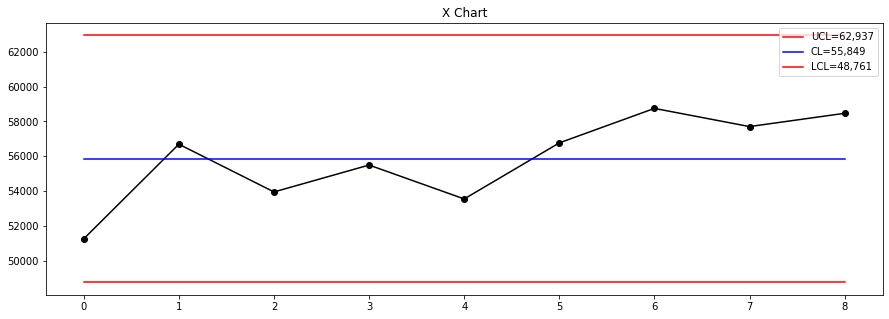

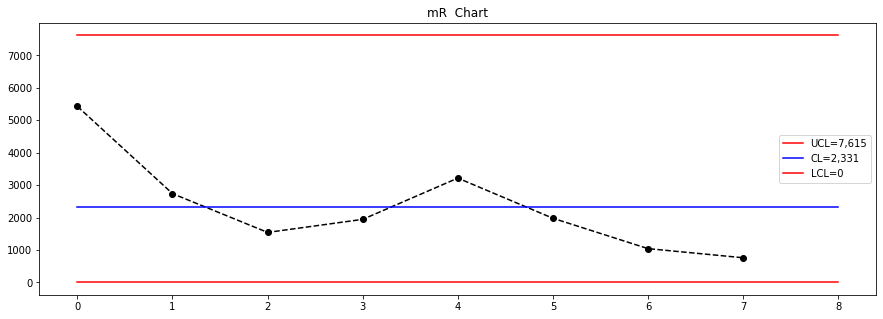

In [18]:
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
chart = SPC()
chart.fit(FilteredDate1['SalesAmount'].to_numpy())
chart.QCC()  

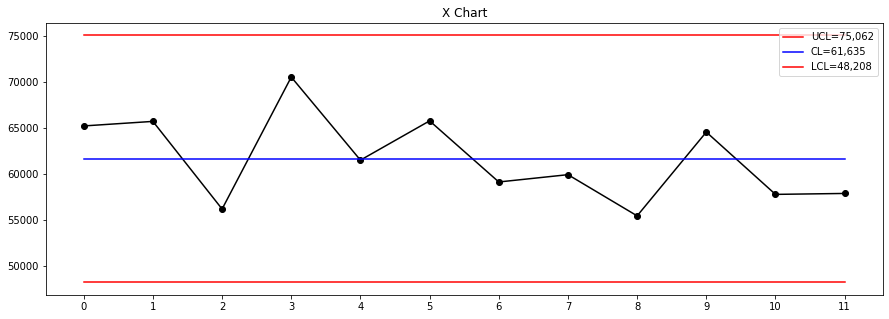

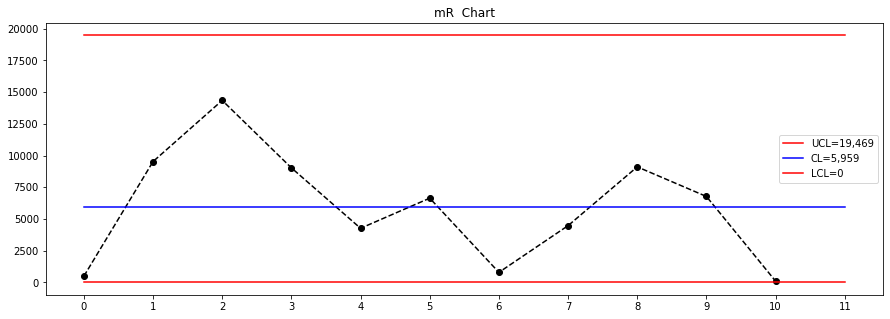

In [19]:
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
chart = SPC()
chart.fit(FilteredDate2['SalesAmount'].to_numpy())
chart.QCC()  

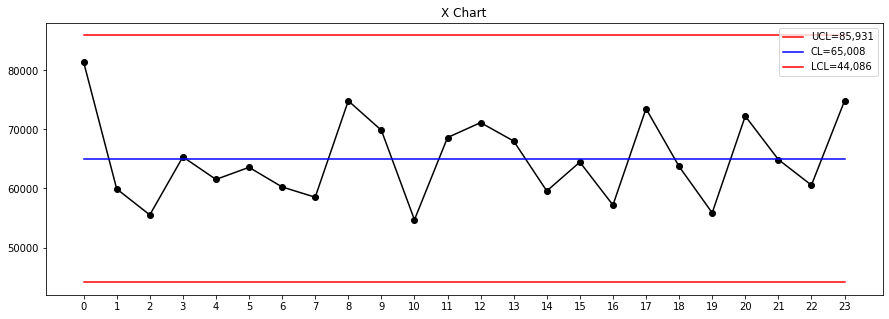

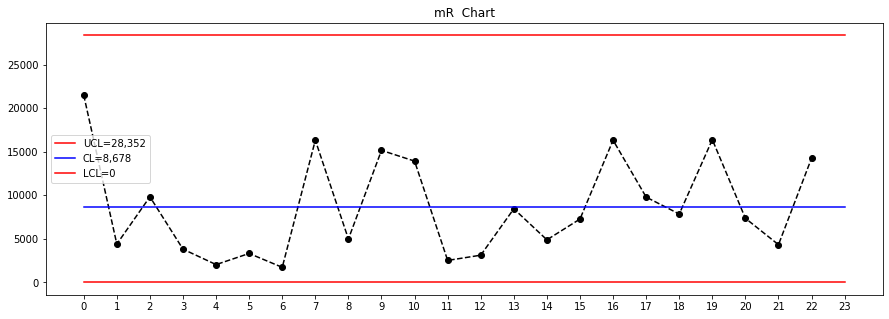

In [20]:
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
chart = SPC()
chart.fit(FilteredDate3['SalesAmount'].to_numpy())
chart.QCC()  